In [51]:
import pykat
import numpy as np

import pykat.ifo.aligo as aligo
import pykat.ifo.aligo.plot
import matplotlib.pyplot as plt
from matplotlib.ticker import FormatStrFormatter

import scipy
from scipy import signal

pykat.init_pykat_plotting(fmts=['svg'])

In [52]:
### Create the baseline file

### Get the DARM Cavity Pole from the shot noise
#%run LHO.py
#base0= make_LHO()

base0 = aligo.make_kat("design_with_IMC_HAM2_FI_OMC", keepComments=True, preserveConstants=True)

base0.L0.P.value = 30

#Sometimes this setup crashes so I just keep trying
result = None
while result is None:
    try:
        base0 = aligo.setup(base0)
        print("Zero-ing locks")
        base0.IFO.zero_locks() #Find phases to lock the IFO
        result = 1
    except:
        pass
        print("Ran into a pykat error, trying again")
    
base_tunings = base0.IFO.get_tunings()


Pykat parsing does not preserve inline comments. Moving inline
comments before command

Zero-ing locks


In [53]:
print(base_tunings)

{'PRM': 0.001, 'ITMX': -0.001, 'ETMX': -0.004401120735871634, 'ITMY': 0.001, 'ETMY': 0.004401120735871634, 'BS': 0.0, 'SRM': -89.999, 'keys': {'phase': 2, 'maxtem': None}}


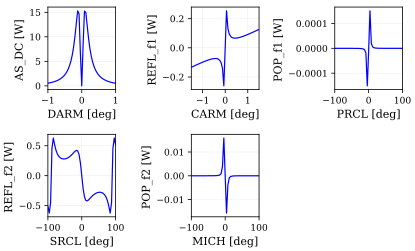

In [54]:
aligo.plot.error_signals(base0, xlimits=(-1, 1), steps=50)

In [55]:
### Add some detectors
base0.parse('''
pd0 POP_DC nPOP
pd1 POP_RF90_I 90994710.0 max nPOP
pd1 POP_RF18_I 18198942.0 max nPOP

%%% FTblock powers
###########################################################################
pd P_DC_AS nAS
pd PIMCtrans nREFL*
pd Px nITMX2
pd Py nITMY2
pd Pprc nPRM2
pd Psrc nSRM1*
ad prc0 0 nPRM2
ad prcf1 $f1 nPRM2
ad prcf2 $f2 nPRM2

ad asc0 0 nSRM2
ad asf1 $f1 nSRM2
ad asf2 $f2 nSRM2
ad src0 0 nSRM1*
ad srcf1 $f1 nSRM1*
ad srcf2 $f2 nSRM1*
###########################################################################
%%% FTend powers

%%% FTblock errsigs
###########################################################################

# N.B. the I signal refers to most symmetric signal, not greatest slope.
pd1 REFL_f1_I $f1 101 nREFL
pd1 REFL_f1_Q $f1 191 nREFL
pd1 REFL_f2_I $f2 14 nREFL
pd1 REFL_f2_Q $f2 104 nREFL
pd1 POP_f1_I $f1 101 nPOP
pd1 POP_f1_Q $f1 191 nPOP
pd1 POP_f2_I $f2 13 nPOP
pd1 POP_f2_Q $f2 103 nPOP
pd1 AS_f1_I $f1 0 nSRM2
pd1 AS_f1_Q $f1 90 nSRM2
pd1 AS_f2_I $f2 13 nSRM2
pd1 AS_f2_Q $f2 103 nSRM2
#pd1 OMClockpd $fdither -1.22 nAS

###########################################################################
%%% FTend errsigs

''')

In [56]:
base0.ITMX.L = 2.5e-5
base0.ITMY.L = 2.5e-5

base0.ITMX.T = 0.0142
base0.ITMY.T = 0.0148

base0.ETMX.L = 3.0e-5
base0.ETMY.L = 3.0e-5

base0.ETMX.T = 3.9e-6
base0.ETMY.T = 3.9e-6

In [57]:
kat0 = base0.deepcopy()
kat0.parse('''
noxaxis
''')
out0 = kat0.run()

PRG=(out0['POP_DC']/kat0.PR2.T.value)/kat0.L0.P.value
print(PRG)

54.00648215889533


In [58]:
out0['Px']/kat0.L0.P.value/PRG

133.3373060685893

In [59]:
base0.ITMX.T

<Param (ITMX.T=0.0142) at 0x254d11340f0>

In [60]:
kat = base0.deepcopy()
kat.parse('''
pd0 POP_DC nPOP
pd1 POP_RF90_I 90994710.0 max nPOP
pd1 POP_RF18_I 18198942.0 max nPOP

variable dummy 0
xaxis dummy re lin 0 10u 100

put* ITMX_lens p $x1
put* ITMY_lens p $mx1

pd Prc nPRM2
pd Pin nPRMs2*
''')

result = None

kat.IFO.suspend_mirrors_z()
kat.IFO.fix_mirrors()

out=kat.run()

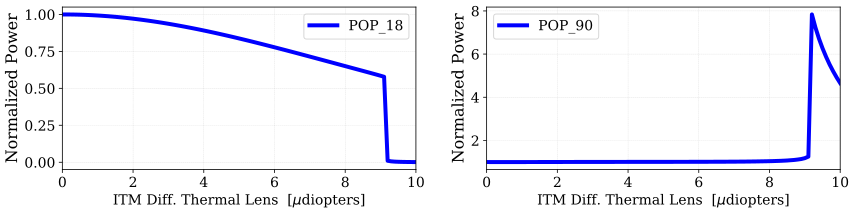

In [61]:
fig = plt.figure(figsize=(14,3),dpi=100)

ax = fig.add_subplot(121)
ax.plot( (out.x)*1e6,out['POP_RF18_I']/out['POP_RF18_I'][0], linewidth=4, label='POP_18')
ax.set_ylabel('Normalized Power', fontsize=16)
ax.set_xlabel('ITM Diff. Thermal Lens  [$\mu$diopters]',fontsize=14)
ax.tick_params(axis='both', labelsize=14)
plt.legend(fontsize=14)

ax = fig.add_subplot(122)
ax.plot( (out.x)*1e6,out['POP_RF90_I']/out['POP_RF90_I'][0], linewidth=4,label='POP_90')
ax.set_xlabel('ITM Diff. Thermal Lens  [$\mu$diopters]',fontsize=14)
ax.set_ylabel('Normalized Power', fontsize=16)
ax.tick_params(axis='both', labelsize=14)
ax.grid()
plt.legend(fontsize=14)

plt.grid()
plt.savefig('../../../Figures/POP18_POP90_DiffLens.png')